In [1]:
# Global imports

import biosteam as bst
import thermosteam as tmo
import biorefineries as bf
from biorefineries import cellulosic
from biosteam import main_flowsheet as F

# Local imports
from lignin_saf.ligsaf_units import SolvolysisReactor, HydrogenolysisReactor, PSA, CatalystMixer
from lignin_saf.ligsaf_chemicals import create_chemicals
from lignin_saf.ligsaf_settings import rcf_oil_yield
from lignin_saf.ligsaf_settings import prices, feed_parameters, rcf_conditions, solvolysis_parameters, meoh_h2o, methanol_to_biomass, h2_biomass_ratio, RCF_catalyst

from ligsaf_tea import ConventionalEthanolTEA
from cellulosic_tea import create_cellulosic_ethanol_tea

bst.nbtutorial() # Light-mode html diagrams and filter warnings

In [2]:
# Code just to increase the number of display units for the various components
tmo.Stream.display_units.N = 40       # Increasing number of display units to see all components of streams 
tmo.MultiStream.display_units.N = 40  
bst.Stream.display_units.N = 40       # Increasing number of display units to see all components of streams 
bst.MultiStream.display_units.N = 40  

In [3]:
chems = create_chemicals()
bst.settings.set_thermo(chems)

In [4]:
bst.settings.CEPCI = 541.7   # CEPCI for 2016, set to same as Bartling paper

In [5]:
cat_replace = 1                    # [/yr] catalyst replacement rate


In [6]:
# Defining poplar group based off composition given in Bartling et al Table S1

chems.define_group(
    name='Poplar',
    IDs=['Glucan',      # Changed cellulose to glucan name here # Cellulase break this down to glucose
         'Xylan',       # Hemicellulose
         'Arabinan',    # Hemicellulose
         'Mannan',      # Hemicellulose
         'Galactan',    # Hemicellulose
         'Sucrose',   
         'Lignin',
         'Acetate',
         'Extract',     # Non structural component of biomass that dissolves in solvent/water 
         'Ash'],
    composition=[0.464,      # Dry wt composition, feed also has 20 wt% moisture content
                 0.134,
                 0.002,
                 0.037,
                 0.014,
                 0.001,
                 0.285,
                 0.035,
                 0.016,
                 0.012],
    wt=True
)


In [7]:
meoh_recycle = bst.MultiStream('Meoh_recycle', phases = ('s','l','g'))

In [8]:
# Inlet poplar stream, should ideally be a solid-liquid stream but the cellulosic ethanol model 
# in BioSTEAM takes in feedstocks as liquid composiiton only and hence I define it solely
# as a liquid. Native compopunds like lignin are also described solely as liquid only in BioSTEAM
poplar_in = bst.Stream('Poplar_In',
                Poplar =  feed_parameters['flow']*1e3, Water = feed_parameters['moisture'] *feed_parameters['flow'] * 1e3,
                 phase = 'l', units='kg/d')



In [9]:
meoh_in = bst.Stream('Meoh_in',
                    Methanol =  (methanol_to_biomass*feed_parameters['flow']*1e3*0.9),
                    Water =  methanol_to_biomass*feed_parameters['flow']*1e3*(1/meoh_h2o)*0.9,
                     phase = 'l',   
                     units = 'L/d')

# Set as a MultiStream to make it easier later on as this stream will also contain carbohydrate
# derivatives (solids) following solvolysis and hydrogen (gas) following hydrogenolysis

# both flows multipled by 0.9 to make the overall meoh_in to biomass liter to kg ratio as 90 which is a requirement

In [10]:
meoh_h2o_mix = bst.units.Mixer('MIX100', ins = (meoh_in, meoh_recycle), rigorous = True)
@meoh_h2o_mix.add_specification(run = True)
def meoh_water_flow():
    fresh_solvent = meoh_h2o_mix.ins[0]
    recycle_solvent = meoh_h2o_mix.ins[1]

    meoh_flow_mol  = (((methanol_to_biomass*feed_parameters['flow']*1e3*0.9)/1000)/24) * chems['Methanol'].rho(phase = 'l', T = rcf_conditions['T'], P = rcf_conditions['P'])  * (1/chems['Methanol'].MW)  # Converting flow from L/day to kmol/hr
    fresh_solvent.imol['Methanol'] = meoh_flow_mol - recycle_solvent.imol['Methanol']

    water_flow_mol = ((methanol_to_biomass*feed_parameters['flow']*1e3*(1/meoh_h2o)*0.9)/1000/24) * chems['Water'].rho(phase = 'l', T = rcf_conditions['T'], P = rcf_conditions['P'])  * (1/chems['Water'].MW) 
    fresh_solvent.imol['Water'] = water_flow_mol - recycle_solvent.imol['Water']
meoh_h2o_mix.simulate()
meoh_h2o_mix.outs[0].phases = ('s', 'l','g')  # These phases must be available for solvolysis and hydrogenolysis reactors downstream

In [11]:
meoh_pump = bst.units.Pump('PUMP101', ins = meoh_h2o_mix-0, P = rcf_conditions['P'])
meoh_heater = bst.units.HXutility('HX102', ins = meoh_pump-0, T = rcf_conditions['T'], rigorous = True)
meoh_pump.simulate()
meoh_heater.simulate()
meoh_heater.outs[0].phases = ('l','g')  # These phases must be available for solvolysis and hydrogenolysis reactors downstream

In [12]:

# Checks to ensure the correct methanol to biomass and methanol to water ratio is used
meoh_biomass_ratio_check = round((meoh_heater.outs[0].F_vol*1000)/(2e6/24),0)
methanol_water_ratio_check = round(meoh_heater.outs[0].ivol['Methanol']/meoh_heater.outs[0].ivol['Water'],0)

if meoh_biomass_ratio_check == methanol_to_biomass:
    print('Correct methanol to biomass ratio')

else:
    raise ValueError(f'Methanol to biomass ratio is {meoh_biomass_ratio_check} L/kg dry biomass \n It must be {methanol_to_biomass} L/kg dry biomass as specified')

if methanol_water_ratio_check == meoh_h2o:
    print('Correct methanol water ratio')

else:
    raise ValueError(f'Methanol water ratio is {methanol_water_ratio_check} \n It must be {meoh_h2o}')


Correct methanol to biomass ratio
Correct methanol water ratio


In [13]:

# Solvolysis reaction to solubilize lignin from cell wall
solvolysis_rxn = bst.Reaction('Lignin -> SolubleLignin', reactant = 'Lignin', X = solvolysis_parameters['Delignification'], basis = 'wt', correct_atomic_balance = False) 
# correct atomic balance set to False because we are working with pseudocomponents


# Methanol decomposition to light gases
methanol_decomposition_rxn = bst.ParallelReaction([
    bst.Reaction('Methanol,l -> Methane,g', reactant = 'Methanol', phases = 'lg', X = solvolysis_parameters['MeOH_CH4'] ,basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('Methanol,l -> CO,g', reactant = 'Methanol', phases = 'lg', X= solvolysis_parameters['MeOH_CO'], basis = 'wt', correct_atomic_balance=False)
])


In [14]:
meoh_initial_rho = chems['Methanol'].rho(phase = 'l', T = 18, P = 101325)
meoh_rcf_in_rho = chems['Methanol'].rho(phase = 'l', T = 200+273.15, P = 6e6)
print(f'Methanol density at initial conditions is {round(meoh_initial_rho,2)} kg/m3')
print(f'Methanol density at initial conditions is {round(meoh_rcf_in_rho,2)} kg/m3')
print(f'Bartling et al for 9 L/kg ratio refer to preheated meoh hence heating methanol \nbefore imposing specification of 9 L/kg')

Methanol density at initial conditions is 904.61 kg/m3
Methanol density at initial conditions is 580.17 kg/m3
Bartling et al for 9 L/kg ratio refer to preheated meoh hence heating methanol 
before imposing specification of 9 L/kg


In [15]:
solvolysis_reactor = SolvolysisReactor('RCF103-S', ins = (poplar_in, meoh_heater-0), outs = ('Carbohydrate_Pulp', 'Solvolysis_Liquor'),
                                    T = rcf_conditions['T'],
                                    P = rcf_conditions['P'],
                                    tau = rcf_conditions['tau_s'], 
                                    # N_beds = 14,
                                    void_frac= 0.5,
                                    superficial_velocity = 0.001, 
                                    reaction_1 = solvolysis_rxn,
                                    reaction_2 = methanol_decomposition_rxn)                                   
solvolysis_reactor.simulate()

# Yes, some of the bounds exceed the limits, but its primarily due to high solvent loadings in 
# the solvolysis reactor

In [16]:
## Independent pressure drop calculator for verifying purposes


bed_length = 2.5

def pressure_drop_function(D, rho, mu, epsilon, u, bed_length):
    Re = (D*rho*u)/mu
    if Re/(1-epsilon) < 500: # Erun equation
        f = ((1-epsilon)/(epsilon**3))*(1.75+(150*(1-epsilon)/Re))
        dP = (f * ((rho*(u**2))/D)* bed_length)*1e-5
    elif 1000 < Re/(1-epsilon) < 5000: # Handley and Heggs
        f = ((1-epsilon)/(epsilon**3))*(1.24+(368*(1-epsilon)/Re))
        dP = (f * ((rho*(u**2))/D)* bed_length)*1e-5
    else: # Hicks equation which fits in Wentz and Thodos results for very high Re
        f = 6.8*(((1-epsilon)**1.2)/epsilon**3)*Re**-0.2
        dP = (f * ((rho*(u**2))/D) * bed_length)*1e-5
    return dP
    

#P = pressure_drop_function(D = 0.0037, rho = 0.9487, mu = 3.1e-5, epsilon = 0.38, u = 1.37, bed_length = 2.5)
#print(f'Pressure drop for example is {round(P,3)} bar') 

# This check is from the textbook Chemical Reactor Analysis and Design Example 11.5.1.A just to show the algorithsm working

P2 = pressure_drop_function(D = 0.004, rho = meoh_heater.outs[0].rho, mu = meoh_heater.outs[0].mu, epsilon = 0.5, u = 0.001, bed_length = 20.41)
print(f'Pressure drop for solvolysis is {round(P2,7)} bar')



Pressure drop for solvolysis is 0.0005918 bar


In [17]:
hydrogen_in = bst.Stream('Hydrogen_In', 
                         Hydrogen = h2_biomass_ratio * 2e6,   # Anderson et al, had MeOH/H2 feeds as 1:100 vol:vol ratio
                         units = 'kg/day',
                         T = 80+273.15,                   # 80 C outlet temperature of PEM electrolysis
                         P = 3e6,                         # 30 bar outlet pressure of H2 through PEM electrolysis
                         phase = 'g'
)

In [18]:
hydrogen_recycle = bst.Stream('hydrogen_recycle', P = 3e6, phase = 'g')


In [19]:
h2_mixer = bst.units.Mixer('MIX104', ins = (hydrogen_in, hydrogen_recycle))
@h2_mixer.add_specification(run = True)
def h2_flow():
    fresh_h2 = h2_mixer.ins[0]
    recycle_h2 = h2_mixer.ins[1]

    h2_flow = (h2_biomass_ratio * (2e6/24)) # * (1/chems['Hydrogen'].MW)
    fresh_h2.imass['Hydrogen'] = h2_flow - recycle_h2.imass['Hydrogen']

h2_mixer.simulate()
h2_mixer.outs[0].phase = 'g'

In [20]:
h2_pre_heat = bst.units.HXutility('HX105', ins = h2_mixer-0, T = rcf_conditions['T'], rigorous = True)
h2_pre_heat.simulate()

h2_pre_heat.outs[0].phase = 'g'

In [21]:
hydrogenolysis = bst.ParallelReaction([
    bst.Reaction('SolubleLignin,l ->Propylguaiacol,l', reactant = 'SolubleLignin', phases = 'lg', X = rcf_oil_yield['Monomers']*0.5, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l ->Propylsyringol,l', reactant = 'SolubleLignin', phases = 'lg', X = rcf_oil_yield['Monomers']*0.5, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l -> Syringaresinol,l', reactant= 'SolubleLignin',phases = 'lg', X = rcf_oil_yield['Dimers']*0.5, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l -> G_Dimer,l', reactant= 'SolubleLignin', phases = 'lg',X = rcf_oil_yield['Dimers']*0.5, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l -> S_Oligomer,l', reactant= 'SolubleLignin',phases = 'lg', X = rcf_oil_yield['Oligomers']*0.5, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l -> G_Oligomer,l', reactant= 'SolubleLignin', phases = 'lg',X = rcf_oil_yield['Oligomers']*0.5, basis = 'wt', correct_atomic_balance=False),
])

In [22]:
hydrogenolysis_reactor = HydrogenolysisReactor('RCF106-H', ins = (solvolysis_reactor.outs[1], h2_pre_heat-0), 
                                               tau = rcf_conditions['tau_h'], 
                                               P = rcf_conditions['P'],
                                               T = rcf_conditions['T'],
                                               superficial_velocity= 0.003, 
                                               reaction = hydrogenolysis, 
                                               N_reactors = 8)
hydrogenolysis_reactor.simulate()

In [23]:
R102 = bst.units.Flash('FLASH107', ins = hydrogenolysis_reactor-0, T = 320, P = 5e5)
R102.simulate()

In [24]:
pre_psa_pump = bst.units.IsentropicCompressor('PUMP108', ins = R102-0, P = 5e5, vle = True)
pre_psa_pump.simulate()
pre_psa_flash = bst.units.Flash('FLASH109', ins = pre_psa_pump-0, T = 260, P = 5e5)
pre_psa_flash.simulate()
pre_psa_heater = bst.units.HXutility('HX110', ins = pre_psa_flash-0, T = 303, rigorous = True)
pre_psa_heater.simulate()
pre_psa_heater.outs[0].phase = 'g'  # It will be a gaseous stream anyways, but my doing so, I am asserting that 
# it is not a MultiStream with avaialble gas and liquid phases

In [25]:
psa_system = PSA('PSA111', ins = pre_psa_heater.outs[0], outs = ('', 'Purge_Light_Gases'))
psa_system.simulate()

In [26]:
h2_pump = bst.units.IsentropicCompressor('PUMP112', ins = psa_system-0, outs = hydrogen_recycle, P = 3e6, vle = True)
h2_pump.simulate()
h2_pump.outs[0].phase = 'g'

In [27]:
crude_distillation = bst.units.BinaryDistillation('DIST113', ins = R102-1, 
                                                LHK = ('Methanol', 'Water'),
                                                  Lr = 0.9995,  Hr = 1-0.967, P = 101325,
                                                  vessel_material = 'Stainless steel 316',
                                                  k = 2, partial_condenser = True) 
# Recovery values from Bartling et al 
crude_distillation.simulate()

In [28]:
meoh_purifier_col = bst.units.BinaryDistillation('DIST114', ins = crude_distillation-0,
                                                 outs = (' ', 'To_WW_Treatment'),
                                                LHK = ('Methanol', 'Water'),
                                                 y_top = 0.9, x_bot = 0.001, P = 101325,
                                                 k = 2)
meoh_purifier_col.simulate()



In [29]:
meoh_mixer = bst.units.Mixer('MIX116', ins = (meoh_purifier_col-0, pre_psa_flash-1), rigorous = True)
meoh_mixer.simulate()

In [30]:
cooler_2 = bst.units.HXutility('HX117', ins = meoh_mixer.outs[0], outs = meoh_recycle, V = 0, rigorous = True)
cooler_2.simulate()

In [31]:
meoh_purifier_col.outs[0].show(flow = 'L/hr', composition = True)
# Composition as expected and required

Stream:   from <BinaryDistillation: DIST114> to <Mixer: MIX116>
phase: 'g', T: 341.48 K, P: 101325 Pa
composition (%): Water     10
                 Methanol  90
                 Methane   0.000836
                 --------  3.66e+08 L/hr


In [32]:
water_remover = bst.units.Flash('FLASH118', ins = crude_distillation-1, outs = ('To WW_Treatment_2', 
                                                                    'RCF_Oil'), T = 400, P = 101325)
water_remover.simulate()

In [33]:
wastewater_mixer = bst.Mixer(ins = (meoh_purifier_col.outs[1],water_remover.outs[0]), outs = 'RCF_WW')
wastewater_mixer.simulate()

In [34]:
# catalyst_opex = CatalystMixer(ins = )

In [35]:
catalyst = bst.Stream('RCF_Catalyst', NiC = RCF_catalyst['loading']*(feed_parameters['flow']*1e3), units = 'kg/yr', price = prices['NiC_catalyst'] )
catalyst_stream = CatalystMixer(ins = catalyst)
catalyst_stream.simulate()
#prices['NiC_catalyst']*catalyst_loading*(feed_parameters['flow']*1e3)


In [36]:

#BT = bst.facilities.BoilerTurbogenerator(fuel_price = 0.2612)   # Boiler turbogenerator
#BT.ins[1] = psa_system.outs[1]               # Takes in the purge gases from PSA 
#WWT = create_conventional_wastewater_treatment_system(ins=wastewater_mixer.outs[0]) 
# WWT will take in the methanol water acetate stream and purify it. methanol is a digestbile so will get digested. 
# Acetate however is non digestible 

In [37]:
# HXN = bst.HeatExchangerNetwork('HXN', T_min_app = 10.)   # Heat integrations taken care off by heat echanger network with an approahc temperature of 10 C, as speciifed by Bartling et al

In [38]:
#flowsheet_sys = bst.main_flowsheet.create_system('flowsheet_sys')
#flowsheet_sys.simulate()


In [39]:
#flowsheet_sys.show()

In [40]:
rcf_system = bst.System('RCF_System', path = (meoh_h2o_mix,meoh_pump, meoh_heater, solvolysis_reactor, h2_mixer, h2_pre_heat, hydrogenolysis_reactor, 
                                              R102, pre_psa_pump, pre_psa_flash, pre_psa_heater, 
                                              psa_system, h2_pump ,crude_distillation, meoh_purifier_col, meoh_mixer, cooler_2, 
                                              water_remover, wastewater_mixer, catalyst_stream), 
                                              # facilities = [BT, WWT],
                                              recycle = (meoh_recycle, hydrogen_recycle))
rcf_system.simulate()

In [41]:
etoh_system = cellulosic.create_cellulosic_ethanol_system(ins = rcf_system.products[0])
etoh_system.simulate()

In [42]:
etoh_system.units[34].ins[2] = rcf_system.products[3] # Adding wastewater stream to cellulois ethanol's wastewater treatment system
etoh_system.units[58].ins[1] = rcf_system.products[1] # The purge light gases from PSA will go to the boiler turbogenererator


In [43]:
integrated_sys = bst.System('RCF_EtOH',
                        path=(rcf_system, etoh_system))
integrated_sys.simulate()

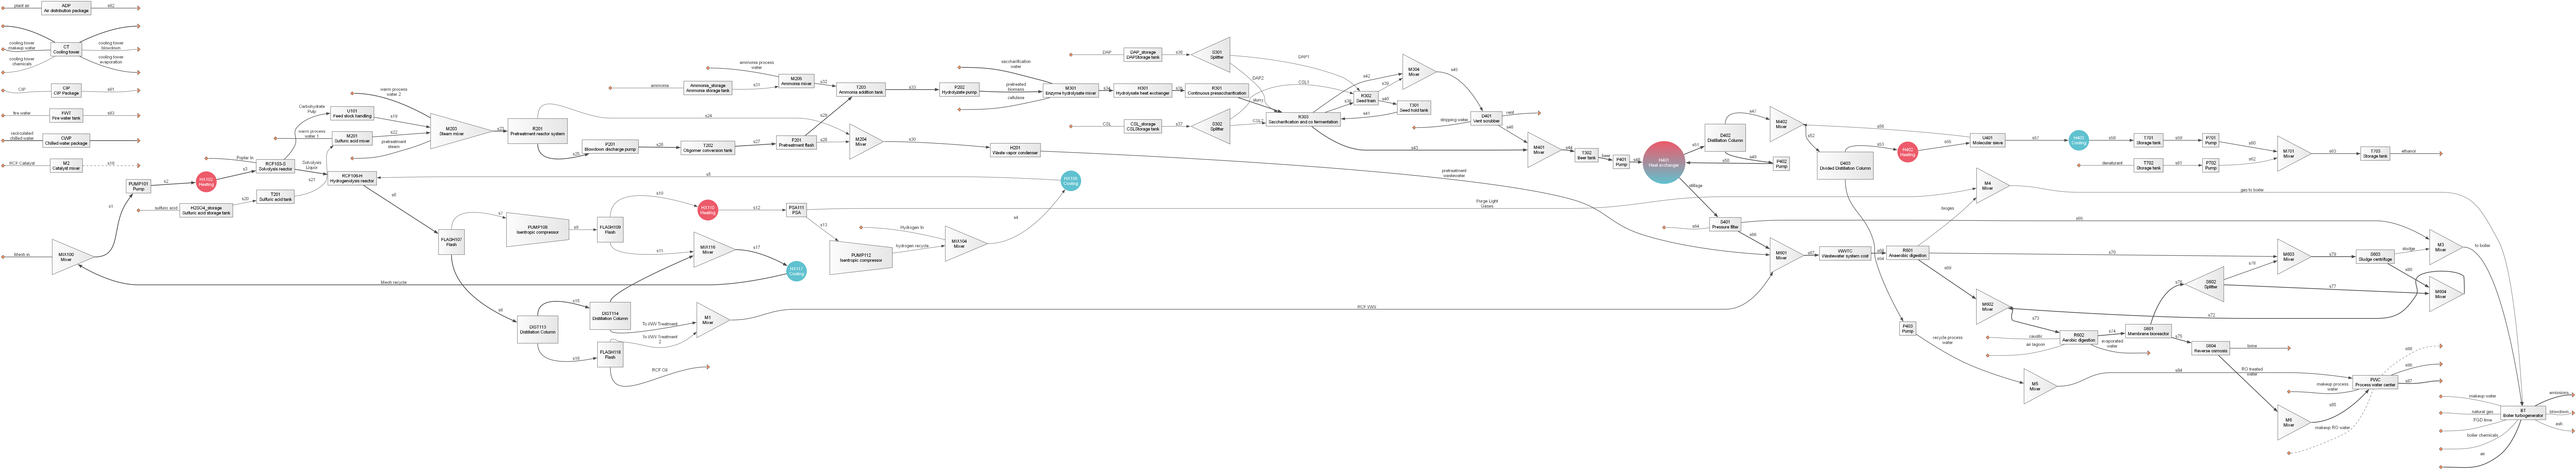

In [44]:

integrated_sys.diagram(format = 'png')

In [45]:
# integrated_sys.diagram(format = 'png', file = 'integrated_system_7')

In [46]:
    operators_per_section = 1  # operators per section from Seider recommendation
    num_process_sections = 3  # number of proces sections from Seider recommendation [2 reactor, 1 separation]
    num_operators_per_shift = operators_per_section * num_process_sections * 1  # multiplied by 2 for large continuous flow process (e.g., 1000 ton/day product). from Seider pg 505
    num_shifts = 5  # number of shifts
    pay_rate = 40  # $/hr
    DWandB = num_operators_per_shift * num_shifts * 2080 * pay_rate  # direct wages and benefits. DWandB [$/year] = (operators/shift)*(5 shifts)*(40 hr/week)*(operating days/year-operator)*($/hr)
    Dsalaries_benefits = 0.15 * DWandB  # direct salaries and benefits from Seider
    O_supplies = 0.06 * DWandB  # Operating supplies and services from Seider
    technical_assistance = 5 * 75000  # $/year. Technical assistance to manufacturing. assume 5 workers at $75000/year
    control_lab = 5 * 80000  # $/year. Control laboratory. assume 5 workers at $80000/year
    labor = DWandB + Dsalaries_benefits + O_supplies + technical_assistance + control_lab 

   

In [47]:
# Prices for all streams
meoh_frac_in_feed = integrated_sys.feeds[0].imass['Methanol']/integrated_sys.feeds[0].F_mass
F.Meoh_in.price = meoh_frac_in_feed* prices['Methanol']     
F.Poplar_In.price = prices['Feedstock'] 
F.Hydrogen_In.price = prices['Hydrogen']      
F.sulfuric_acid.price = prices['H2SO4']
F.ammonia.price = prices['NH3']
F.cellulase.price = prices['Cellulase'] 
F.CSL.price = prices ['CSL'] 
F.DAP.price = prices['DAP'] 
F.caustic.price = prices['Caustic']
F.denaturant.price =  prices['Denaturant'] 
F.cooling_tower_chemicals.price = prices['CT_chemicals'] 
F.FGD_lime.price = prices['FOD_lime']
F.boiler_chemicals.price = prices['Boiler_chemicals'] 



In [48]:
integrated_tea = create_cellulosic_ethanol_tea(integrated_sys)

In [49]:
print(f'The MSP for crude RCF oil is  {round(integrated_tea.solve_price(F.RCF_Oil),3)} USD/kg')

The MSP for crude RCF oil is  1.242 USD/kg


In [50]:
rcf_reactor_installed_cost = (solvolysis_reactor.installed_cost +hydrogenolysis_reactor.installed_cost)

In [51]:
print('BioSTEAM system installed equipment cost is', round(integrated_sys.installed_equipment_cost / 1e6, 2), 'MM USD')
print('BioSTEAM system RCF reactor costs only are', round(rcf_reactor_installed_cost / 1e6, 2), 'MM USD')
print('BioSTEAM system purchased equipment cost is', round(integrated_sys.purchase_cost / 1e6, 2), 'MM USD')

BioSTEAM system installed equipment cost is 442.98 MM USD
BioSTEAM system RCF reactor costs only are 221.57 MM USD
BioSTEAM system purchased equipment cost is 228.69 MM USD


In [52]:
print(f'The Wastewater system cost is {round(F.WWTC.installed_cost/1e6,2)} MM USD')

The Wastewater system cost is 49.85 MM USD


In [53]:
storage_cost = (F.T701.installed_cost +F.T702.installed_cost+F.T703.installed_cost + F.H2SO4_storage.installed_cost)
print(f'Storage tank cost is {round(storage_cost/1e6,2)} MM USD')

Storage tank cost is 2.43 MM USD


In [54]:
utilities_cost = F.CWP.installed_cost + F.ADP.installed_cost + F.FWT.installed_cost + F.CT.installed_cost + 957234 + F.PWC.installed_cost
print(f'Utility installed cost is {round(utilities_cost/1e6,2)} MM USD')

Utility installed cost is 5.44 MM USD


In [55]:
print(f'The Boiler Turbogenerator cost is {round(F.BT.installed_cost/1e6,2)} MM USD')

The Boiler Turbogenerator cost is 52.1 MM USD


In [56]:
integrated_tea.TCI

841917850.6257675

In [57]:
etoh_reaction_separationcost = etoh_system.installed_cost - storage_cost - utilities_cost - F.BT.installed_cost - F.WWTC.installed_cost

In [58]:
etoh_reaction_separationcost/1e6

73.7298654152745

In [59]:
F.CIP

Stream: CIP to <CIPpackage: CIP>
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (kmol/hr): Water  4.85


In [60]:
F.R601.installed_cost + F.R602.installed_cost + F.S601.installed_cost + F.S603.installed_cost + F.S604.installed_cost

0

In [61]:
F.diagram()

In [62]:
F.unit

Registry:
<Mixer: MIX100>
<Pump: PUMP101>
<HXutility: HX102>
<SolvolysisReactor: RCF103-S>
<Mixer: MIX104>
<HXutility: HX105>
<HydrogenolysisReactor: RCF106-H>
<Flash: FLASH107>
<IsentropicCompressor: PUMP108>
<Flash: FLASH109>
<HXutility: HX110>
<PSA: PSA111>
<IsentropicCompressor: PUMP112>
<BinaryDistillation: DIST113>
<BinaryDistillation: DIST114>
<Mixer: MIX116>
<HXutility: HX117>
<Flash: FLASH118>
<Mixer: M1>
<CatalystMixer: M2>
<FeedStockHandling: U101>
<SulfuricAcidStorageTank: H2SO4_storage>
<SulfuricAcidTank: T201>
<SulfuricAcidMixer: M201>
<SteamMixer: M203>
<PretreatmentReactorSystem: R201>
<BlowdownDischargePump: P201>
<OligomerConversionTank: T202>
<PretreatmentFlash: F201>
<Mixer: M204>
<WasteVaporCondenser: H201>
<AmmoniaStorageTank: Ammonia_storage>
<AmmoniaMixer: M205>
<AmmoniaAdditionTank: T203>
<HydrolyzatePump: P202>
<EnzymeHydrolysateMixer: M301>
<HydrolysateHeatExchanger: H301>
<ContinuousPresaccharification: R301>
<DAPStorageTank: DAP_storage>
<MockSplitter: S301

In [63]:
integrated_sys.WastewaterSystemCost

AttributeError: 'System' object has no attribute 'WastewaterSystemCost'

In [ ]:
F.WastewaterSystemCost

AttributeError: no registered item 'WastewaterSystemCost'

In [ ]:
integrated_sys.results()

System                            Units  RCF_EtOH
Electricity              Power       kW     2e+03
                         Cost    USD/hr       156
Cooling water            Duty     kJ/hr -6.85e+08
                         Flow   kmol/hr  4.68e+05
                         Cost    USD/hr       228
Chilled water            Duty     kJ/hr -5.14e+08
                         Flow   kmol/hr   3.4e+05
                         Cost    USD/hr  2.57e+03
Low pressure steam       Duty     kJ/hr  1.04e+09
                         Flow   kmol/hr   2.7e+04
                         Cost    USD/hr  6.42e+03
Medium pressure steam    Duty     kJ/hr         0
                         Flow   kmol/hr         0
                         Cost    USD/hr         0
High pressure steam      Duty     kJ/hr  5.06e+08
                         Flow   kmol/hr  1.57e+04
                         Cost    USD/hr  4.98e+03
Propane                  Duty     kJ/hr -9.61e+06
                         Flow   kmol/hr       522
                         Cost    USD/hr       127
Fuel (inlet)             Flow     kg/hr       421
                         Cost    USD/hr      91.8
Process water (inlet)    Flow     kg/hr  1.54e+04
                         Cost    USD/hr      4.15
Ash disposal (outlet)    Flow     kg/hr  1.46e+03
                         Cost    USD/hr      46.3
Total purchase cost                 USD  2.29e+08
Installed equipment cost            USD  4.43e+08
Utility cost                     USD/hr  1.46e+04
Material cost                    USD/hr   1.6e+04
Sales                            USD/hr  1.56e+04

In [ ]:
F.unit

Registry:
<Mixer: MIX100>
<Pump: PUMP101>
<HXutility: HX102>
<SolvolysisReactor: RCF103-S>
<Mixer: MIX104>
<HXutility: HX105>
<HydrogenolysisReactor: RCF106-H>
<Flash: FLASH107>
<IsentropicCompressor: PUMP108>
<Flash: FLASH109>
<HXutility: HX110>
<PSA: PSA111>
<IsentropicCompressor: PUMP112>
<BinaryDistillation: DIST113>
<BinaryDistillation: DIST114>
<Mixer: MIX116>
<HXutility: HX117>
<Flash: FLASH118>
<Mixer: M1>
<FeedStockHandling: U101>
<SulfuricAcidStorageTank: H2SO4_storage>
<SulfuricAcidTank: T201>
<SulfuricAcidMixer: M201>
<SteamMixer: M203>
<PretreatmentReactorSystem: R201>
<BlowdownDischargePump: P201>
<OligomerConversionTank: T202>
<PretreatmentFlash: F201>
<Mixer: M204>
<WasteVaporCondenser: H201>
<AmmoniaStorageTank: Ammonia_storage>
<AmmoniaMixer: M205>
<AmmoniaAdditionTank: T203>
<HydrolyzatePump: P202>
<EnzymeHydrolysateMixer: M301>
<HydrolysateHeatExchanger: H301>
<ContinuousPresaccharification: R301>
<DAPStorageTank: DAP_storage>
<MockSplitter: S301>
<CSLStorageTank: C

In [ ]:
print('BioSTEAM system TCI cost is', round(integrated_tea.TCI / 1e6, 2), 'MM USD')

BioSTEAM system TCI cost is 841.81 MM USD


In [ ]:
F.RCF_Oil.show(composition = True, flow = 'kg/hr')

Stream: RCF_Oil from <Flash: FLASH118>
phase: 'l', T: 400 K, P: 101325 Pa
composition (%): Extract         5.37
                 Glucan          15.6
                 Xylan           3.15
                 Arabinan        0.403
                 Mannan          6.21
                 Galactan        2.35
                 Propylguaiacol  16.7
                 Propylsyringol  16.7
                 Syringaresinol  8.37
                 G_Dimer         8.37
                 S_Oligomer      8.37
                 G_Oligomer      8.37
                 --------------  2.48e+04 kg/hr


In [ ]:
F.ethanol.show(flow = 'L/yr')

Stream: ethanol from <StorageTank: T703>
phase: 'l', T: 339.26 K, P: 101325 Pa
flow (L/yr): Water       1.57e+06
             Ethanol     2.47e+08
             NH3         2.1e+05
             Denaturant  6.16e+06


In [ ]:
integrated_sys.power_utility

PowerUtility:
consumption: 2.51e+04 kW
production: 2.31e+04 kW
power: 2e+03 kW
cost: 156 USD/hr


In [ ]:
integrated_sys.results()

System                            Units  RCF_EtOH
Electricity              Power       kW     2e+03
                         Cost    USD/hr       156
Cooling water            Duty     kJ/hr -6.85e+08
                         Flow   kmol/hr  4.68e+05
                         Cost    USD/hr       228
Chilled water            Duty     kJ/hr -5.14e+08
                         Flow   kmol/hr   3.4e+05
                         Cost    USD/hr  2.57e+03
Low pressure steam       Duty     kJ/hr  1.04e+09
                         Flow   kmol/hr   2.7e+04
                         Cost    USD/hr  6.42e+03
Medium pressure steam    Duty     kJ/hr         0
                         Flow   kmol/hr         0
                         Cost    USD/hr         0
High pressure steam      Duty     kJ/hr  5.06e+08
                         Flow   kmol/hr  1.57e+04
                         Cost    USD/hr  4.98e+03
Propane                  Duty     kJ/hr -9.61e+06
                         Flow   kmol/hr       522
                         Cost    USD/hr       127
Fuel (inlet)             Flow     kg/hr       421
                         Cost    USD/hr      91.8
Process water (inlet)    Flow     kg/hr  1.54e+04
                         Cost    USD/hr      4.15
Ash disposal (outlet)    Flow     kg/hr  1.46e+03
                         Cost    USD/hr      46.3
Total purchase cost                 USD  2.29e+08
Installed equipment cost            USD  4.43e+08
Utility cost                     USD/hr  1.46e+04
Material cost                    USD/hr   1.6e+04
Sales                            USD/hr  1.56e+04

for i unit in enumerate(integrated_sys.units):


In [ ]:
print('BioSTEAM system variable OPEX is', round((rcf_system.material_cost + rcf_system.utility_cost) / 1e6, 3), 'MM USD/yr')

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [ ]:
import pandas as pd
purchase_df = pd.DataFrame({
    'Unit': [u.ID for u in integrated_sys.cost_units],                          # The system here is named my_sys
    'Installed Cost': [u.installed_cost for u in integrated_sys.cost_units]
})
purchase_df.to_excel('integrated system installed costs.xlsx', index=False)
purchase_df

In [ ]:
*** Break***

In [ ]:

import pandas as pd
# Code to estimate the utility cost of equipments

records = []

for unit in rcf_system.units:
    # Utility cost (electricity, steam, etc.)
    utility_cost = getattr(unit, 'utility_cost', 0.0) or 0.0
    
    # Additional OPEX (user-defined; stored as a dictionary)
    #additional_opex_dict = getattr(unit, 'add_OPEX', {})
    #additional_cost = additional_opex_dict.get('Additional OPEX', 0.0) if additional_opex_dict else 0.0

    total_opex = utility_cost 
    
    records.append({
        'Unit ID': unit.ID,
        'Unit Type': type(unit).__name__,
        'Utility Cost [USD/hr]': utility_cost,
        #'Additional OPEX [USD/hr]': additional_cost,
        'Total Operating Cost [USD/hr]': total_opex
    })

df_opex = pd.DataFrame(records).sort_values(by='Total Operating Cost [USD/hr]', ascending=False)

from IPython.display import display
display(df_opex)

Cost breakdown graph

In [ ]:
# Defining different categories

rcf_area = [meoh_h2o_mix, meoh_pump, meoh_heater, solvolysis_reactor, h2_mixer, h2_pre_heat, hydrogenolysis_reactor, h2_pump, cooler_2] 

hydrogen_purification = [R102, pre_psa_pump, pre_psa_flash, pre_psa_heater,psa_system]

methanol_recovery = [crude_distillation, meoh_purifier_col]

# other = [water_remover]

boiler = [BT]

wastewater = [WWT]


In [ ]:
# CAPEX breakdown [USD]

rcf_installed_cost = sum(u.installed_cost for u in rcf_area)
hydrogen_purification_installed_cost = sum(u.installed_cost for u in hydrogen_purification)
methanol_recovery_installed_cost = sum(u.installed_cost for u in methanol_recovery)
boiler_installed_cost = sum(u.installed_cost for u in boiler)
wwt_installed_cost = sum(u.installed_cost for u in wastewater)
# other_installed_cost = sum(u.installed_cost for u in other)


#installed_costs = np.array([cat_upgrading_installed_cost, prod_frac_installed_cost, storage_installed_cost,
#                            0, 0, 0])

In [ ]:
round(rcf_tea.installed_equipment_cost/1e6, 2)

In [ ]:
# Code for generating Installed Costs breakdown
'''
import matplotlib.pyplot as plt
plt.rc('font',family='Arial')

# Dummy data
values = [rcf_installed_cost, hydrogen_purification_installed_cost, methanol_recovery_installed_cost,boiler_installed_cost,wwt_installed_cost]

# Colors for the slices (change as needed)
colors = ['#88CCEE', '#DDCC77', '#CC6677',  "#19A078","#2F032F"]

fig, ax = plt.subplots(figsize=(5, 5))

# Pie chart with percent labels outside
wedges, texts, autotexts = ax.pie(
    values, 
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,

    wedgeprops=dict(edgecolor='black', linewidth=2),

    pctdistance=1.35,    # move percent labels outside
    textprops={'fontsize': 24}
)



# Optional: remove slice value labels inside the pie
for text in texts:
    text.set_visible(False)

# Title (place above, e.g. for TCI value)
#plt.text(0, 1.45, 'Capital Costs', ha='center', va='center', fontsize=24, fontweight='bold')
#plt.text(0, 1.2, f'TIC: {round(rcf_tea_2.installed_equipment_cost/1e6, 2)} MM$', ha='center', va='center', fontsize=22)

# Remove axes for cleaner look
ax.axis('equal')
plt.tight_layout()
#plt.savefig("rcf_installed_cost_breakdown.png", dpi=500, bbox_inches='tight')
#plt.show()
'''

In [ ]:
# Code for generating legend for installed cost breakdown

'''
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rc('font',family='Arial')
# Define categories and corresponding colors from original vertical legend
categories_styled = [
    "RCF reactors",
    "Hydrogen purification",
    "Methanol recovery",
    "Boiler/Turbogenerator",
    "Wastewater treatment"
]

colors_styled = [
'#88CCEE', '#DDCC77', '#CC6677',  "#19A078","#2F032F"
]

patches = [mpatches.Patch(facecolor=color, label=label, edgecolor='black', linewidth=1.2) 
           for color, label in zip(colors_styled, categories_styled)]

fig, ax = plt.subplots(figsize=(10, 2))

# Create legend
legend = ax.legend(
    handles=patches,
    loc='center',
    ncol=1,
    frameon=False,        # No frame around the entire legend
    fontsize=16,
    handlelength=3,
    handletextpad=0.3,
    borderpad=10.8,
    columnspacing=0.8,
    labelspacing=0.3
)

# Ensure no text boxes
for text in legend.get_texts():
    text.set_bbox(None)

ax.axis('off')
#plt.tight_layout()
#plt.savefig("legend_tci.png", dpi=500)
#plt.show()
'''

In [ ]:
#BREAK

In [ ]:
#rcf_system.material_cost

In [ ]:
chems['Methanol']

In [ ]:
round((chems['Glycerol'].Psat(T = 225+273.15))/1e5,2)

In [ ]:
#bst.plot_vle_binary_phase_envelope(['Water', 'Isopropylalcohol'], P=101325)


In [ ]:
# HXN = bst.HeatExchangerNetwork('HXN', T_min_app = 10., replace_unit_heat_utilities = True)

In [ ]:
#hx_sys = bst.System('hx_sys', path = (meoh_h2o_mix,meoh_pump, meoh_heater, solvolysis_reactor, h2_mixer, h2_pre_heat, hydrogenolysis_reactor, 
#                                              R102, pre_psa_pump, pre_psa_flash, pre_psa_heater, 
#                                              psa_system, h2_pump ,crude_distillation, meoh_purifier_col, meoh_mixer, cooler_2, 
#                                              water_remover, h2o_mixer, wastewater_mixer), facilities =  [BT, WWT, HXN], recycle = (meoh_recycle, hydrogen_recycle))
#hx_sys.simulate()

In [ ]:
#hx_tea = create_cellulosic_ethanol_tea(hx_sys)

In [ ]:
import pandas as pd
for u in rcf_system.units:
    if hasattr(u, 'power_utility'):
        print(f"{u.ID} electricity: {u.power_utility.rate:.2f} kW")

    if hasattr(u, 'heat_utilities'):
        for h in u.heat_utilities:
            print(f"{u.ID} {h.duty/1e6:.2f} MJ/hr")


utility_df_2 = pd.DataFrame({
    'Unit': [u.ID for u in rcf_system.cost_units if hasattr(u, 'power_utility')],                          # The system here is named my_sys
    'Heat Utilities': [u.heat_utilities for u in rcf_system.cost_units if hasattr(u, 'heat_utilities')],
    'Power utilities': [u.power_utility.rate for u in rcf_system.cost_units if hasattr(u, 'power_utility')]
})            

In [ ]:
utility_df_2.to_excel('utility_df.xlsx')

In [ ]:
print(f'Bartling et al system installed system cost is {round(((290362170+33147597)/1e6),2)} MM USD')
print(f'Variable OPEX is 156.7 MM USD/yr')

In [ ]:
print(f'Crude RCF Oil production is {round((rcf_system.products[0].F_mass*24*330)/1e6,2)} MM kg/yr') 
print(f'In Bartling et al, it is 185.9 MM kg/yr')
print(f'Difference is probably because they also consider loss of Arabinan Galactan and Mannan which I do not')
print(f'But our amounts of carbohydrate extractives were similar so this is probably not it')

In [ ]:
monomers_kg_hr = rcf_system.products[0].imass['Propylguaiacol'] + rcf_system.products[0].imass['Propylsyringol']

In [ ]:
print(f'The monomer yield obtained here is {round((monomers_kg_hr/(2000/24)),2)} kg/dry metric ton biomass') 
print(f'In Bartling et al, this is 88.4 kg/dry metric ton biomass')
print('Difference might be due to recovery of RCF Oil, in my case its a 100% recovery\nIn Bartling et al., it is 91.8%')
# Seems that yields are better, so RCF price should technically be lower...

In [ ]:
rcf_reactor_purchase_cost = solvolysis_reactor.purchase_cost +hydrogenolysis_reactor.purchase_cost
rcf_reactor_installed_cost = rcf_reactor_purchase_cost*my_tea.lang_factor
print(f'RCF Reactor only Installed Costs are {round((rcf_reactor_installed_cost/1e6),2)} MM USD')
print(f'In Bartling et al, these are {round((290362170/1e6),2)} MM USD')
print('Simply lovely')

In [ ]:
# Since reactor costs are not that different, it could be that the operating expenses are
# causing the difference between MSPs

In [ ]:
import pandas as pd
from IPython.display import display

records = []

for unit in rcf_system.units:    # system name is my_sys here
    heat_utilities = getattr(unit, 'heat_utilities', [])  # Default to empty list if not present
    total_duty = sum(h.duty for h in heat_utilities if h.duty != 0)  # Can also use h.duty > 0 for heating only

    records.append({
        'Unit ID': unit.ID,
        'Unit Type': type(unit).__name__,
        'Utility [kJ/hr]': total_duty
    })

df_opex = pd.DataFrame(records)

# Remove zero-utility rows (optional)
df_opex = df_opex[df_opex['Utility [kJ/hr]'] != 0]

# Sort in descending order of heat duty
df_opex = df_opex.sort_values(by='Utility [kJ/hr]', ascending=False).reset_index(drop=True)

total_heat = df_opex['Utility [kJ/hr]'].sum()
df_opex['% of Total'] = df_opex['Utility [kJ/hr]'] / total_heat 
#df_opex.to_excel('heat_utilities_summary.xlsx', index=False)

display(df_opex)

In [ ]:
total_heating = df_opex[df_opex['Utility [kJ/hr]'] > 0]['Utility [kJ/hr]'].sum()
total_cooling= -df_opex[df_opex['Utility [kJ/hr]'] < 0]['Utility [kJ/hr]'].sum()

In [ ]:
print(f'Total RCF heat demand is {round((total_heating/1e3/3600),2)} MJ/s')
print('For Bartling et al, this value is 295.2 MJ/s')
# So heat demand is way higher

In [ ]:
bst.settings.get_agent('natural_gas').regeneration_price /(16)

In [ ]:
total_heating*(bst.settings.get_agent('natural_gas').regeneration_price /(16))

In [ ]:
# rcf_system()

In [ ]:
print(f'Total RCF cooling demand is {round((total_cooling/1e3/3600),2)} MJ/s')

In [ ]:
bst.settings.get_heating_agent('high_pressure_steam')

In [ ]:
# So from the prices it seems as if natural gas is way more expensive than HP stem
# Lets see if my system is using natural gas

In [ ]:

def find_units_using_agent(agent_ID, system=None):
    agent = bst.settings.get_agent(agent_ID)
    if not agent:
        print(f"No agent found with ID '{agent_ID}'")
        return []

    if system is None:
        system = rcf_system

    units_using_agent = []

    for unit in system.units:
        if hasattr(unit, 'heat_utilities'):
            for hu in unit.heat_utilities:
                if hu.agent is agent:
                    units_using_agent.append((unit.ID, hu.duty, hu.agent.ID))

    return units_using_agent

# Example usage
results = find_units_using_agent('natural_gas')

# Display results
if results:
    print(f"\nUnits using agent 'ethylene':")
    for ID, duty, agent_ID in results:
        print(f" - Unit {ID} | Duty: {duty:.2f} kJ  | Agent: {agent_ID}")
else:
    print("No units are using this agent.")

In [ ]:
# Wierdly enough, none of the unit ops are using natural gas indicating that evne if my system has
# higher utility requirements, they are being met off by much cheaper utilities

In [ ]:
feedstock_cost = rcf_system.feeds[1].price * rcf_system.feeds[1].F_mass * 24 * 330 
print(f'Feedstock cost is {round((feedstock_cost/1e6),2)} MM USD/year')
print(f'Bartling et al., it is 57.9 MM USD/yr')


In [ ]:
solvent_makeup_cost = rcf_system.feeds[0].F_mass*24*330*rcf_system.feeds[0].price
print(f'Solvent make up cost is {round((solvent_makeup_cost/1e6),2)} MM USD/year')
print(f'In Bartling et al., this cost is 12.1 MM USD/yr')


In [ ]:
rcf_system.utility_cost

In [ ]:
rcf_system.products[4].show(flow = 'kg/hr')

In [ ]:
carbohydrate_content = (1.33e03+3.87e03)
carbohydrate_content/rcf_system.products[4].F_mass

In [ ]:
# I just manually reduced the solvent price, and I found that basically when its the same 
# solvent recovery price as suggested by Bartling et al, the MJSP kind of drops by 50 cents,
# and is 1.51 USD/kg. I also realized that the OPEX goes down by 80 MM USD/yr

In [ ]:
# Even at that point, there is a 46 MM USD/yr difference in OPEX. Sizable chunk probably because of fixed OPEX also in operatinng expenditures in biosteam

In [ ]:
hydrogen_cost = rcf_system.feeds[2].price*rcf_system.feeds[2].F_mass*24*330
print(f'Hydrogen cost is {round((hydrogen_cost/1e6),2)} MM USD/year')
print(f'In Bartling et al., this cost is just 5.5 MM USD/yr')


In [ ]:
break

In [ ]:
HXN = bst.HeatExchangerNetwork('HXN', T_min_app = 5.)


In [ ]:
hx_sys = bst.System.from_units('hx_sys', units = [meoh_h2o_mix, meoh_pump, meoh_heater, solvolysis_reactor, h2_mixer, h2_pre_heat, hydrogenolysis_reactor, 
                                              R102, pre_psa_pump, pre_psa_flash, pre_psa_heater,
                                              psa_system, h2_pump ,crude_distillation, meoh_purifier_col, meoh_mixer, cooler_2, 
                                              water_remover, HXN], facility_recycle= (meoh_recycle, hydrogen_recycle))

In [ ]:
hx_sys.simulate()

In [ ]:
round(HXN.actual_heat_util_load/HXN.original_heat_util_load, 2)


In [ ]:
hx_tea = ConventionalEthanolTEA(system = hx_sys,
                                IRR = 0.10,
                                duration = (2016, 2046),
                                depreciation = 'MACRS7',
                                income_tax = 0.21,
                                operating_days = 330,
                                lang_factor = 4.28,
                                construction_schedule = (0.08, 0.60, 0.32),
                                WC_over_FCI = 0.05,
                                labor_cost =0,
                                #fringe_benefits = 0,
                                property_tax= 0, #0.001, 
                                property_insurance=0, # 0.005, 
                                #supplies=0, 
                                maintenance=0, #0.01, 
                                administration=0 #0.005
                                )

In [ ]:
hx_sys.feeds[0].price = 80/907.18
hx_sys.feeds[1].price = 1.606  
hx_sys.feeds[2].price = 0.27455

In [ ]:
hx_sys.diagram(format = 'png',file = 'hx_sys')

In [ ]:
hx_sys.feeds[2]

In [ ]:
hx_sys.operating_hours = 330 * 24


print('Heat integrated system installed equipment cost is', round(hx_sys.installed_equipment_cost / 1e6, 2), 'MM USD')
print('Heat integrated system OPEX is', round((hx_sys.material_cost + hx_sys.utility_cost) / 1e6, 3), 'MM USD/yr')

In [ ]:
hx_tea.NPV

In [ ]:
hx_sys.outs[3]

In [ ]:
print(f'The MSP is {round(hx_tea.solve_price(hx_sys.outs[3]),4)} USD/kg')

In [ ]:
for u in hx_sys.units:
    if hasattr(u, 'power_utility'):
        print(f"{u.ID} electricity: {u.power_utility.rate:.2f} kW")

    if hasattr(u, 'heat_utilities'):
        for h in u.heat_utilities:
            print(f"{u.ID} {h.duty/1e6:.2f} MJ/hr")

In [ ]:
hx_sys.units

In [ ]:
hx_sys.units[0].results()

In [ ]:
hx_sys.operating_hours = 330 * 24

print('Heat integrated system installed equipment cost is', round(hx_sys.installed_equipment_cost / 1e6, 2), 'MM USD')
print('Heat integrated system OPEX is', round((hx_sys.material_cost + hx_sys.utility_cost) / 1e6, 3), 'MM USD/yr')

In [ ]:
rcf_system.purchase_cost

In [ ]:
hx_sys.purchase_cost

In [ ]:
heat_integrated_purchase_df = pd.DataFrame({
    'Unit': [u.ID for u in hx_sys.cost_units],                          # The system here is named my_sys
    'Purchase Cost': [u.purchase_cost for u in hx_sys.cost_units]
})
# purchase_df.to_excel('equipment_purchase_costs.xlsx', index=False)
heat_integrated_purchase_df

In [ ]:
purchase_df

In [ ]:
print('Heat integrated system OPEX is', round((hx_sys.material_cost + hx_sys.utility_cost) / 1e6, 3), 'MM USD/yr')

In [ ]:
# Add RCF catalyst cost separately as OPEX 

In [ ]:

def find_units_using_agent(agent_ID, system=None):
    agent = bst.settings.get_agent(agent_ID)
    if not agent:
        print(f"No agent found with ID '{agent_ID}'")
        return []

    if system is None:
        system = rcf_system    # Assynes systems name is my_sys

    units_using_agent = []

    for unit in system.units:
        if hasattr(unit, 'heat_utilities'):
            for hu in unit.heat_utilities:
                if hu.agent is agent:
                    units_using_agent.append((unit.ID, hu.duty, hu.agent.ID))

    return units_using_agent

# Example usage
results = find_units_using_agent('medium_pressure_steam')

# Display results
if results:
    print(f"\nUnits using agent 'ethylene':")
    for ID, duty, agent_ID in results:
        print(f" - Unit {ID} | Duty: {duty:.2f} kJ  | Agent: {agent_ID}")
else:
    print("No units are using this agent.")

In [ ]:
import pandas as pd
from IPython.display import display

records = []

for unit in hx_sys.units:    # system name is my_sys here
    heat_utilities = getattr(unit, 'heat_utilities', [])  # Default to empty list if not present
    total_duty = sum(h.duty for h in heat_utilities if h.duty != 0)  # Can also use h.duty > 0 for heating only

    records.append({
        'Unit ID': unit.ID,
        'Unit Type': type(unit).__name__,
        'Utility [kJ/hr]': total_duty
    })

hx_df_opex = pd.DataFrame(records)

# Remove zero-utility rows (optional)
hx_df_opex = hx_df_opex[hx_df_opex['Utility [kJ/hr]'] != 0]

# Sort in descending order of heat duty
hx_df_opex = hx_df_opex.sort_values(by='Utility [kJ/hr]', ascending=False).reset_index(drop=True)

total_heat_hx = hx_df_opex['Utility [kJ/hr]'].sum()
hx_df_opex['% of Total'] = hx_df_opex['Utility [kJ/hr]'] / total_heat_hx
hx_df_opex.to_excel('heat_utilities_summary.xlsx', index=False)

display(hx_df_opex)

In [ ]:
total_heating_hx = hx_df_opex[hx_df_opex['Utility [kJ/hr]'] > 0]['Utility [kJ/hr]'].sum()
# total_cooling_hx= -hx_df_opex[df_opex['Utility [kJ/hr]'] < 0]['Utility [kJ/hr]'].sum()

In [ ]:
print(f'Total RCF heat demand is {round((total_heating_hx/1e3/3600),2)} MJ/s')
print('For Bartling et al, this value is 295.2 MJ/s')

In [ ]:
bst.settings.get_agent('high_pressure_steam').LHV

In [ ]:
bst.settings.get_agent('natural_gas').LHV

In [ ]:
bst.facilities.BoilerTurbogenerator